In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
note_status_tsv = '/content/drive/MyDrive/TFM/noteStatusHistory-00000/noteStatusHistory-00000.tsv'
notesspadf_= '/content/drive/MyDrive/TFM/notesdataspanish_.csv'

df_status = pd.read_csv(note_status_tsv, sep='\t')
notesspadf = pd.read_csv(notesspadf_)

print(f"Note status history: {df_status.shape}")
print(f"Notes spanish: {notesspadf.shape}")

/tmp/ipython-input-2-2965458161.py:4: DtypeWarning: Columns (10,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_status = pd.read_csv(note_status_tsv, sep='\t')


Note status history: (2052557, 23)
Notes spanish: (174464, 24)


/tmp/ipython-input-2-2965458161.py:5: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  notesspadf = pd.read_csv(notesspadf_)


In [ ]:
import pandas as pd

# definimos expl√≠citamente qu√© columnas conservar de df_status
cols_df_status = [col for col in df_status.columns if col not in ['noteId', 'noteAuthorParticipantId', 'createdAtMillis']]

# realizamos el left join solo con las columnas necesarias de df_status
merged = notesspadf.merge(
    df_status[ ['noteId'] + cols_df_status ],  # solo noteId + el resto de columnas no duplicadas
    how='left',
    on='noteId'
)

# eliminamos las columnas obsoletas
merged = merged.drop(columns=['believable', 'harmful', 'validationDifficulty'], errors='ignore')

print(merged.shape)



(174464, 41)


In [ ]:
merged.columns

Index(['noteId', 'noteAuthorParticipantId', 'createdAtMillis', 'tweetId',
       'classification', 'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources', 'summary',
       'isMediaNote', 'summary_language', 'timestampMillisOfFirstNonNMRStatus',
       'firstNonNMRStatus', 'timestampMillisOfCurrentStatus', 'currentStatus',
       'timestampMillisOfLatestNonNMRStatus', 'mostRecentNonNMRStatus',
       'timestampMillisOfStatusLock', 'lockedStatus',
       'timestampMillisOfRetroLock', 'currentCoreStatus',
       'currentExpansionStatus', 'currentGroupStatus', 'currentDecidedBy',
       'currentModelingGroup', 'timestampMillisOf

In [ ]:
# Conversi√≥n de fechas
merged['createdAt'] = pd.to_datetime(merged['createdAtMillis'], unit='ms')
merged['createdMonth'] = merged['createdAt'].dt.to_period('M')


In [ ]:
# Obtener la √∫ltima fecha de tuit en el dataset
ultimo_tweet_fecha = merged['createdAt'].max()
print("√öltima fecha de tuit:", ultimo_tweet_fecha)

# Definir el umbral de dos semanas anteriores
umbral_fecha = ultimo_tweet_fecha - pd.Timedelta(weeks=2)

# Filtrar: quitamos los registros con fecha de creaci√≥n posterior al umbral
#     es decir, nos quedamos con los que sean m√°s antiguos
filtered = merged[merged['createdAt'] <= umbral_fecha].copy()

print(f"Registros finales tras eliminar las dos semanas m√°s recientes: {filtered.shape}")
# ‚ÄúSe han eliminado las notas publicadas en las dos semanas anteriores a la √∫ltima fecha disponible
# para garantizar que las notas hayan completado su proceso de evaluaci√≥n y obtengan
# un estado final consolidado (evitando sesgo por notas en estado transitorio o NMR)‚Äù.


√öltima fecha de tuit: 2025-04-27 01:00:59.174000
Registros finales tras eliminar las dos semanas m√°s recientes: (172231, 43)


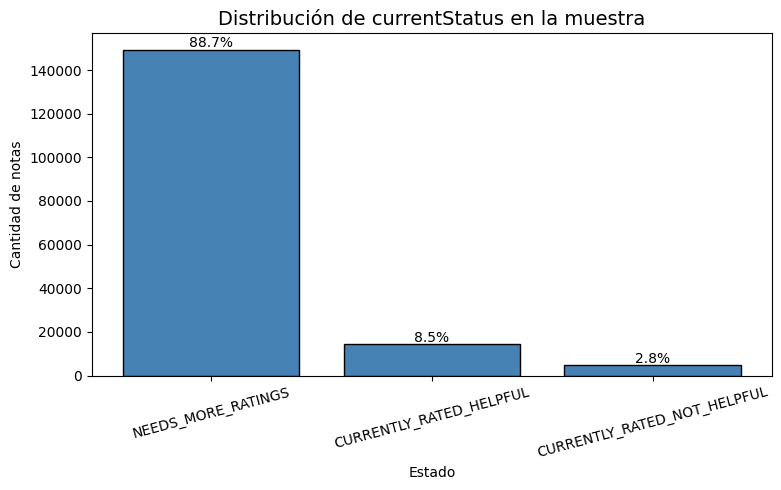

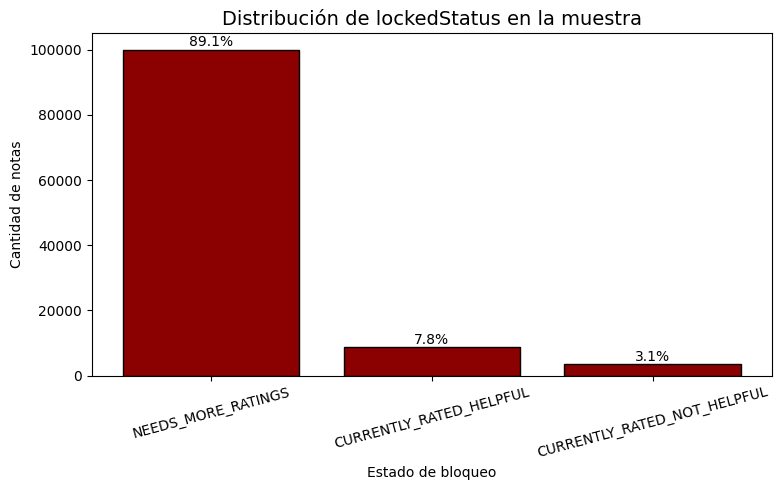

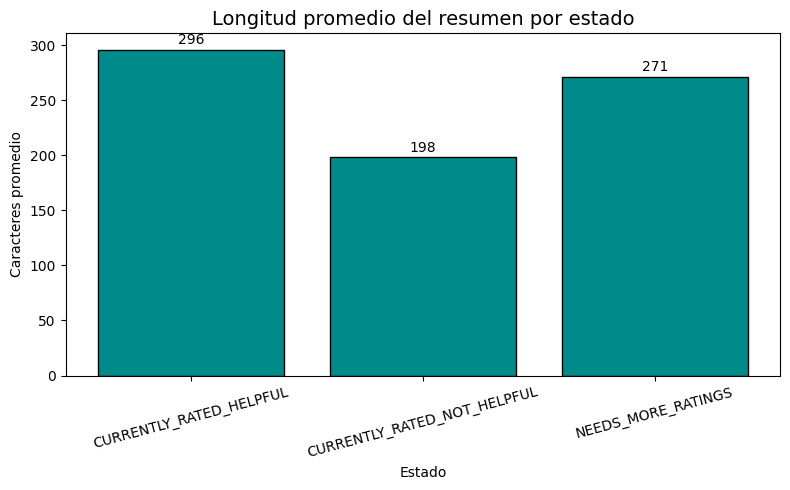

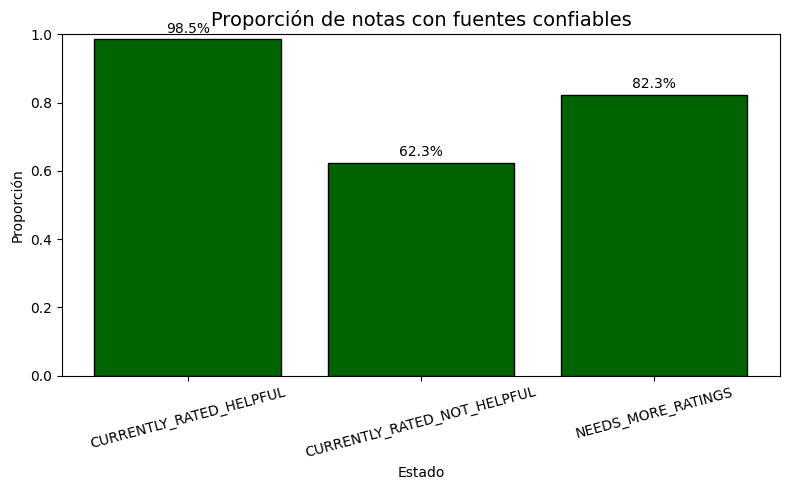

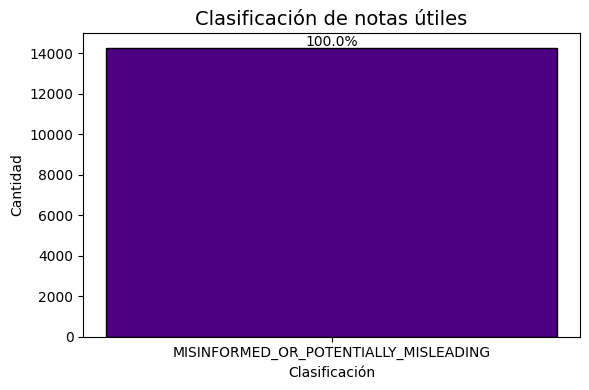

/tmp/ipython-input-7-2557468146.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  total_by_month = merged.set_index('createdAt').resample('M').size()
/tmp/ipython-input-7-2557468146.py:112: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  helpful_by_month = helpful_notes.set_index('createdAt').resample('M').size()


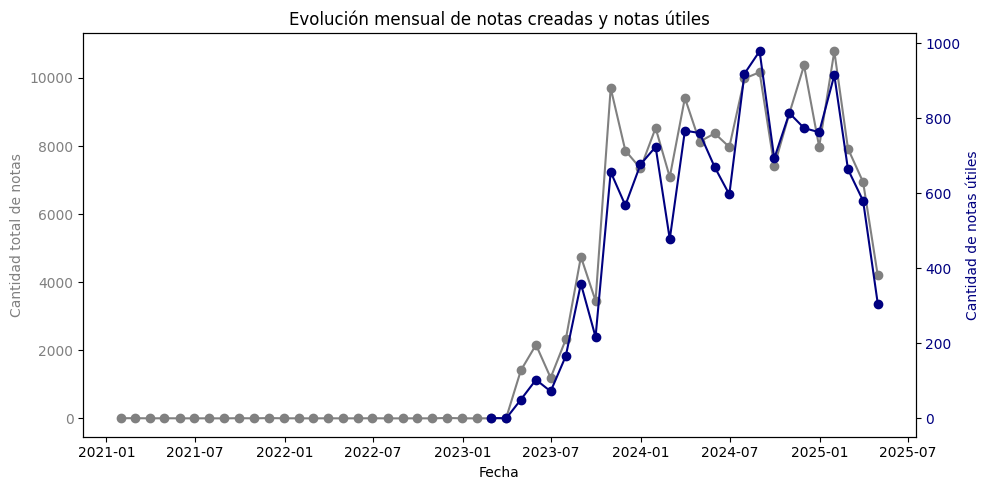

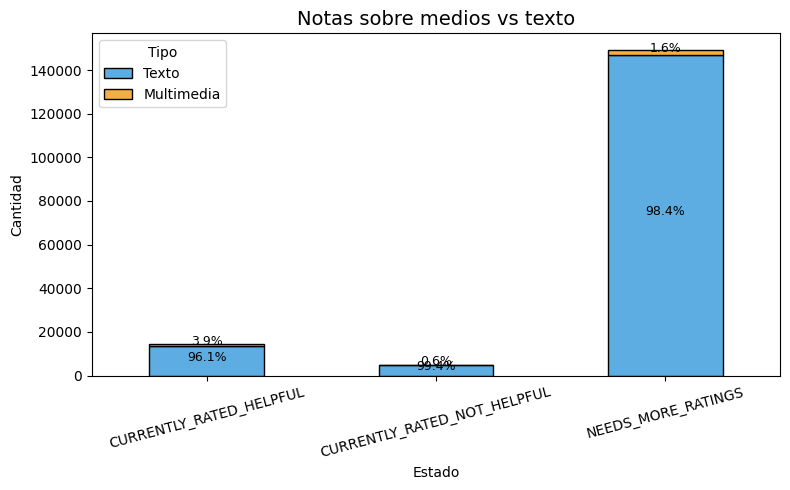

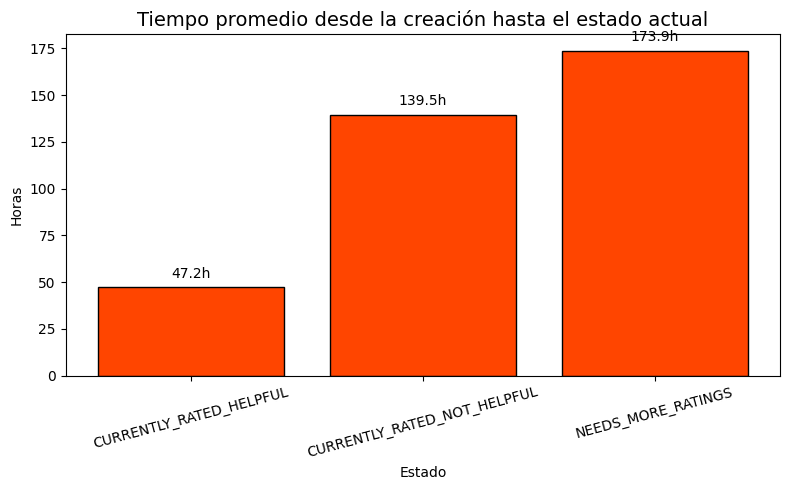

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Estilo
plt.style.use('seaborn-v0_8-muted')

# ==========================
# 0Ô∏è‚É£ Distribuci√≥n de currentStatus con porcentajes
# ==========================
status_counts = merged['currentStatus'].value_counts()
status_percent = status_counts / status_counts.sum() * 100

plt.figure(figsize=(8,5))
bars = plt.bar(status_counts.index, status_counts.values, color='steelblue', edgecolor='black')
plt.title('Distribuci√≥n de currentStatus en la muestra', fontsize=14)
plt.ylabel('Cantidad de notas')
plt.xlabel('Estado')
plt.xticks(rotation=15)

for bar, pct in zip(bars, status_percent):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{pct:.1f}%', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# ==========================
# Distribuci√≥n de lockedStatus con porcentajes
# ==========================
locked_counts = merged['lockedStatus'].value_counts()
locked_percent = locked_counts / locked_counts.sum() * 100

plt.figure(figsize=(8,5))
bars = plt.bar(locked_counts.index, locked_counts.values, color='darkred', edgecolor='black')
plt.title('Distribuci√≥n de lockedStatus en la muestra', fontsize=14)
plt.ylabel('Cantidad de notas')
plt.xlabel('Estado de bloqueo')
plt.xticks(rotation=15)

for bar, pct in zip(bars, locked_percent):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{pct:.1f}%', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# ==========================
# 1Ô∏è‚É£ Longitud de res√∫menes (sin porcentajes porque es promedio)
# ==========================
merged['summaryLength'] = merged['summary'].fillna('').apply(len)
summary_length = merged.groupby('currentStatus')['summaryLength'].mean()

plt.figure(figsize=(8,5))
bars = plt.bar(summary_length.index, summary_length.values, color='darkcyan', edgecolor='black')
plt.title('Longitud promedio del resumen por estado', fontsize=14)
plt.ylabel('Caracteres promedio')
plt.xlabel('Estado')
plt.xticks(rotation=15)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{bar.get_height():.0f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# ==========================
# 2Ô∏è‚É£ Proporci√≥n de fuentes confiables con porcentajes
# ==========================
trustworthy_rate = merged.groupby('currentStatus')['trustworthySources'].mean()

plt.figure(figsize=(8,5))
bars = plt.bar(trustworthy_rate.index, trustworthy_rate.values, color='darkgreen', edgecolor='black')
plt.title('Proporci√≥n de notas con fuentes confiables', fontsize=14)
plt.ylabel('Proporci√≥n')
plt.xlabel('Estado')
plt.ylim(0,1)
plt.xticks(rotation=15)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{bar.get_height()*100:.1f}%', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# ==========================
# 3Ô∏è‚É£ Clasificaci√≥n en notas √∫tiles con porcentajes
# ==========================
helpful_notes = merged[merged['currentStatus']=='CURRENTLY_RATED_HELPFUL']
classification_counts = helpful_notes['classification'].value_counts()
classification_percent = classification_counts / classification_counts.sum() * 100

plt.figure(figsize=(6,4))
bars = plt.bar(classification_counts.index, classification_counts.values, color='indigo', edgecolor='black')
plt.title('Clasificaci√≥n de notas √∫tiles', fontsize=14)
plt.ylabel('Cantidad')
plt.xlabel('Clasificaci√≥n')
plt.xticks(rotation=0)

for bar, pct in zip(bars, classification_percent):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{pct:.1f}%', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# ==========================
# 4Ô∏è‚É£ Evoluci√≥n mensual: notas √∫tiles vs todas
# ==========================

# total de notas creadas por mes
total_by_month = merged.set_index('createdAt').resample('M').size()

# notas √∫tiles por mes (ya ten√≠a helpful_by_month calculado)
helpful_by_month = helpful_notes.set_index('createdAt').resample('M').size()


fig, ax1 = plt.subplots(figsize=(10,5))

color1 = 'gray'
color2 = 'navy'

# eje primario
ax1.plot(total_by_month.index, total_by_month.values, marker='o', color=color1, label='Todas las notas')
ax1.set_ylabel('Cantidad total de notas', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# eje secundario
ax2 = ax1.twinx()
ax2.plot(helpful_by_month.index, helpful_by_month.values, marker='o', color=color2, label='Notas √∫tiles')
ax2.set_ylabel('Cantidad de notas √∫tiles', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Evoluci√≥n mensual de notas creadas y notas √∫tiles')
ax1.set_xlabel('Fecha')
fig.tight_layout()
plt.show()


# ==========================
# 5Ô∏è‚É£ An√°lisis de medios vs texto con porcentajes
# ==========================
media_notes = merged.groupby(['currentStatus', 'isMediaNote']).size().unstack(fill_value=0)

media_percent = media_notes.div(media_notes.sum(axis=1), axis=0) * 100

ax = media_notes.plot(kind='bar', stacked=True, figsize=(8,5),
                      color=['#5DADE2','#F5B041'], edgecolor='black')
plt.title('Notas sobre medios vs texto', fontsize=14)
plt.ylabel('Cantidad')
plt.xlabel('Estado')
plt.legend(title='Tipo', labels=['Texto','Multimedia'])
plt.xticks(rotation=15)

# a√±adir porcentaje en barras
for idx, (state, row) in enumerate(media_notes.iterrows()):
    total = row.sum()
    y_text = 0
    for i, count in enumerate(row):
        pct = (count / total) * 100 if total>0 else 0
        plt.text(idx, y_text + count/2, f'{pct:.1f}%', ha='center', fontsize=9)
        y_text += count
plt.tight_layout()
plt.show()

# ==========================
# 6Ô∏è‚É£ Tiempos de resoluci√≥n (primer cambio de estatus) con valores num√©ricos
# ==========================
merged['timeToFirstStatus'] = (
    (merged['timestampMillisOfFirstNonNMRStatus'] - merged['createdAtMillis']) / (1000*3600)
)

tiempo_medio = merged.groupby('currentStatus')['timeToFirstStatus'].mean()

plt.figure(figsize=(8,5))
bars = plt.bar(tiempo_medio.index, tiempo_medio.values, color='orangered', edgecolor='black')
plt.title('Tiempo promedio desde la creaci√≥n hasta el estado actual', fontsize=14)
plt.ylabel('Horas')
plt.xlabel('Estado')
plt.xticks(rotation=15)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{bar.get_height():.1f}h', ha='center', fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# fechas notas
# Obtener fecha de la nota m√°s antigua
fecha_mas_antigua = merged['createdAt'].min()

# Obtener fecha de la nota m√°s reciente
fecha_mas_reciente = merged['createdAt'].max()

print("üï∞Ô∏è Nota m√°s antigua:", fecha_mas_antigua)
print("üìÖ Nota m√°s reciente:", fecha_mas_reciente)



üï∞Ô∏è Nota m√°s antigua: 2021-01-28 17:52:51.922000
üìÖ Nota m√°s reciente: 2025-04-27 01:00:59.174000


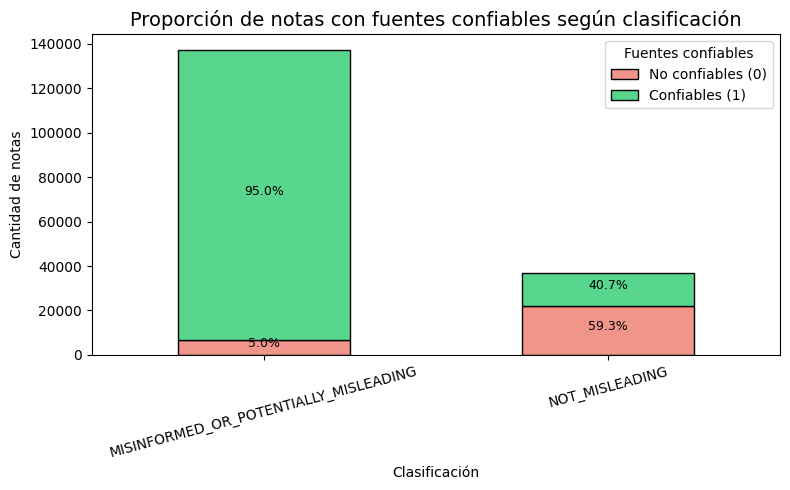

In [ ]:
# agrupamos por classification y trustworthySources
trustworthy_class = merged.groupby(['classification', 'trustworthySources']).size().unstack(fill_value=0)

# Asegurar que el √≠ndice es string
trustworthy_class.index = trustworthy_class.index.astype(str)

# graficar
ax = trustworthy_class.plot(kind='bar', stacked=True,
                            color=['#F1948A','#58D68D'], edgecolor='black', figsize=(8,5))

plt.title('Proporci√≥n de notas con fuentes confiables seg√∫n clasificaci√≥n', fontsize=14)
plt.ylabel('Cantidad de notas')
plt.xlabel('Clasificaci√≥n')
plt.legend(title='Fuentes confiables', labels=['No confiables (0)', 'Confiables (1)'])
plt.xticks(rotation=15)

# a√±adir porcentajes en las barras
for idx, (i, row) in enumerate(trustworthy_class.iterrows()):
    total = row.sum()
    y_text = 0
    for j, count in enumerate(row):
        pct = (count/total)*100 if total > 0 else 0
        plt.text(idx, y_text + count/2, f'{pct:.1f}%', ha='center', fontsize=9)
        y_text += count

plt.tight_layout()
plt.show()


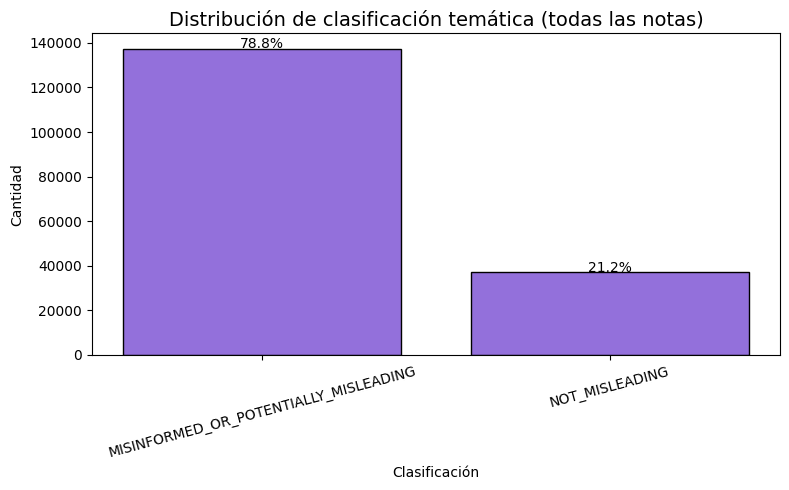

In [ ]:
# Clasificaci√≥n general (en todas las notas)
clasificacion_total = merged['classification'].value_counts()
clasificacion_pct = clasificacion_total / clasificacion_total.sum() * 100

plt.figure(figsize=(8,5))
bars = plt.bar(clasificacion_total.index, clasificacion_total.values, color='mediumpurple', edgecolor='black')
plt.title('Distribuci√≥n de clasificaci√≥n tem√°tica (todas las notas)', fontsize=14)
plt.ylabel('Cantidad')
plt.xlabel('Clasificaci√≥n')
plt.xticks(rotation=15)

for bar, pct in zip(bars, clasificacion_pct):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{pct:.1f}%', ha='center', fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# columnas causas

In [ ]:
# Causas que indican desinformaci√≥n
misleading_cols = [
    'misleadingOther', 'misleadingFactualError', 'misleadingManipulatedMedia',
    'misleadingOutdatedInformation', 'misleadingMissingImportantContext',
    'misleadingUnverifiedClaimAsFact', 'misleadingSatire'
]

# Causas que indican que NO es desinformaci√≥n
not_misleading_cols = [
    'notMisleadingOther', 'notMisleadingFactuallyCorrect',
    'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
    'notMisleadingPersonalOpinion'
]


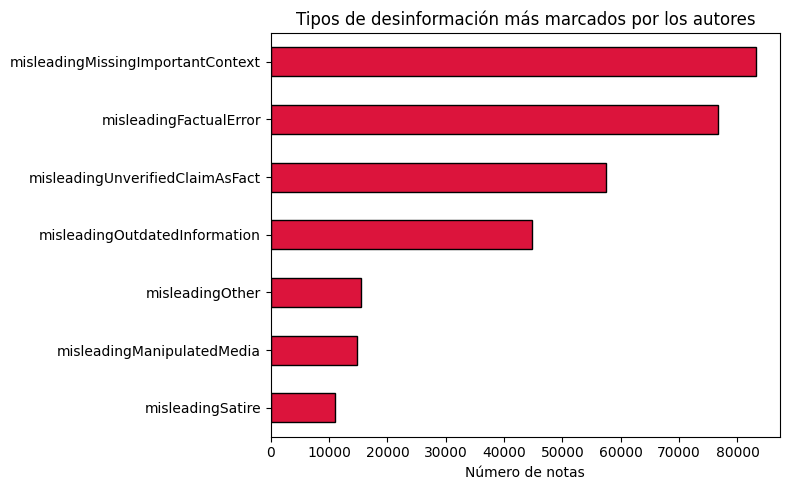

In [ ]:
# causas de notas misleading
misleading_totals = merged[misleading_cols].sum().sort_values(ascending=True)

plt.figure(figsize=(8,5))
misleading_totals.plot(kind='barh', color='crimson', edgecolor='black')
plt.title('Tipos de desinformaci√≥n m√°s marcados por los autores')
plt.xlabel('N√∫mero de notas')
plt.tight_layout()
plt.show()


In [ ]:
# causas not misleading

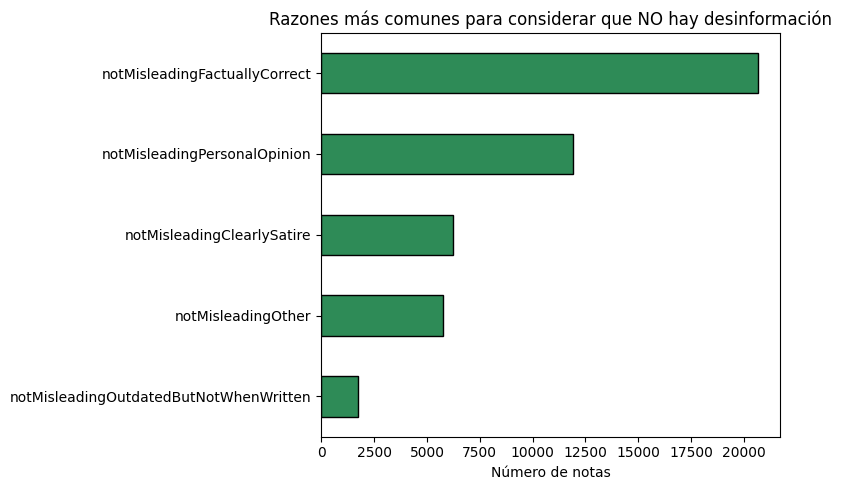

In [ ]:
not_misleading_totals = merged[not_misleading_cols].sum().sort_values(ascending=True)

plt.figure(figsize=(8,5))
not_misleading_totals.plot(kind='barh', color='seagreen', edgecolor='black')
plt.title('Razones m√°s comunes para considerar que NO hay desinformaci√≥n')
plt.xlabel('N√∫mero de notas')
plt.tight_layout()
plt.show()


In [ ]:
merged.groupby('currentStatus')[misleading_cols].mean() * 100


misleadingOther  misleadingFactualError  \
currentStatus                                                          
CURRENTLY_RATED_HELPFUL            10.627715               59.759002   
CURRENTLY_RATED_NOT_HELPFUL         9.553191               24.191489   
NEEDS_MORE_RATINGS                  8.521236               42.698570   

                             misleadingManipulatedMedia  \
currentStatus                                             
CURRENTLY_RATED_HELPFUL                       14.074541   
CURRENTLY_RATED_NOT_HELPFUL                    4.978723   
NEEDS_MORE_RATINGS                             7.938782   

                             misleadingOutdatedInformation  \
currentStatus                                                
CURRENTLY_RATED_HELPFUL                          32.233431   
CURRENTLY_RATED_NOT_HELPFUL                      15.468085   
NEEDS_MORE_RATINGS                               25.107118   

                             misleadingMissingImportantContext  \
currentStatus                                                    
CURRENTLY_RATED_HELPFUL                              55.590584   
CURRENTLY_RATED_NOT_HELPFUL                          26.595745   
NEEDS_MORE_RATINGS                                   47.447244   

                             misleadingUnverifiedClaimAsFact  misleadingSatire  
currentStatus                                                                   
CURRENTLY_RATED_HELPFUL                            40.037831          8.210733  
CURRENTLY_RATED_NOT_HELPFUL                        18.510638          7.872340  
NEEDS_MORE_RATINGS                                 32.482861          6.097692

In [ ]:
merged.groupby('currentStatus')[not_misleading_cols].mean() * 100


notMisleadingOther  \
currentStatus                                     
CURRENTLY_RATED_HELPFUL                0.000000   
CURRENTLY_RATED_NOT_HELPFUL            7.702128   
NEEDS_MORE_RATINGS                     3.571046   

                             notMisleadingFactuallyCorrect  \
currentStatus                                                
CURRENTLY_RATED_HELPFUL                           0.000000   
CURRENTLY_RATED_NOT_HELPFUL                      25.553191   
NEEDS_MORE_RATINGS                               12.836752   

                             notMisleadingOutdatedButNotWhenWritten  \
currentStatus                                                         
CURRENTLY_RATED_HELPFUL                                    0.000000   
CURRENTLY_RATED_NOT_HELPFUL                                3.468085   
NEEDS_MORE_RATINGS                                         1.033019   

                             notMisleadingClearlySatire  \
currentStatus                                             
CURRENTLY_RATED_HELPFUL                        0.000000   
CURRENTLY_RATED_NOT_HELPFUL                    7.425532   
NEEDS_MORE_RATINGS                             3.874993   

                             notMisleadingPersonalOpinion  
currentStatus                                              
CURRENTLY_RATED_HELPFUL                          0.000000  
CURRENTLY_RATED_NOT_HELPFUL                     14.340426  
NEEDS_MORE_RATINGS                               7.415243